# Team2: Pytorch
### Members: 110065508李丞恩 109062676劉廷哲 110062592姜宏昀 110062539古之恒

## (1) Report

- 由於目的是對poisoned image進行training，而clean data又train的很好。所以主要著重在preprocessing的部分，如何對input images進行類似denoise，或是對image進行某種轉換，以得到較高的準確率

- 我們主要依據助教們給的提示來做實驗，主要分為以下三部分

- 以下紀錄的為最終繳交的版本

- 由於時間有些緊迫，所以先在image size較小的cifar10上找出一組比較好的preprocessing組合後，就直接套用在Imagenet上面了。因此Imagenet和Cifar10的preprocessing是相同的

### 1. Model Architecture(10%)

> densenet121, max pooling

### 2. Image Preprocessing(90%)

> color jitter + random channel shuffle

### 3. Training process(0.1%)

> no, only use reduceLR + early stopping

### cifar10

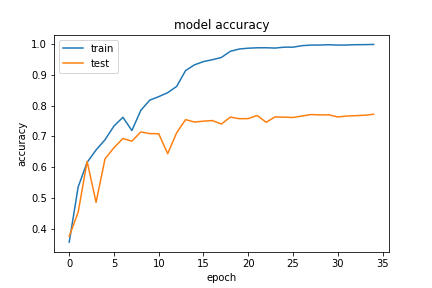

In [4]:
from IPython.display import Image
Image(filename='output_training_plot/cifar10_densenet121.png')

### Imagenet
(由於是從先前pretrained model，fit到不同的類似的input instance，所以會先下降再上升)

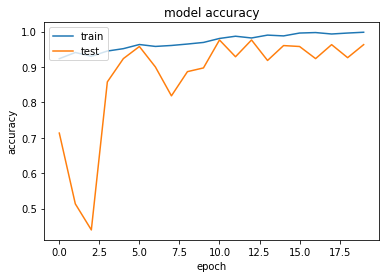

In [5]:
from IPython.display import Image
Image(filename='output_training_plot/imagenet_densenet121.png')

## (2) What we have tried

### 1. Model Architecture
- 有試過像是Resnet、VGG、InceptionV3等model，但densenet121的表現最好
- 試著加上keras內建的preprocessing layer，像是batchNorm, randomflip。但在Imagenet上面的表現差異不大
- 直接使用densenet121內建的top layer(include_top = true)，會比自己進行flatten、dropout再dense的結果好
- 在imagenet時有試過用average pooling，在public leaderboard會比max pooling的0.94到達0.96，但不知為何在private leaderboard時卻是max pooling的結果比較好

### 2. Image Preprocessing
- 我們用Albumentations package內的preprocessing function對cifar10 dataset進行各種可能的轉換。（實驗紀錄請看最後的cell）

- 實驗發現和channels、色調有關，或是pixel-wise的operation的表現很不錯，而單純flip, rotate沒有用。
> 像是channel shuffle、 飽和度、色調，或是灰階都可以有不錯的準確率

- 最終選擇color jitter + random channel shuffle

### 3. Training process

- 沒有用特別的training process
- 只有在training時用reduce learning rate + early stopping，在validation acc高時還能稍微改善一些，也能早點prune掉沒用的preprocess方法

### 4. Auto Encoder

我們嘗試了Denoise Auto Encoder的方法，主要是希望透過auto encoder的特性，看能不能在還原的過程中，把雜訊消除掉，我們嘗試了兩種不同的方法

> autoencoder為 x --encoder--> c --decoder--> $\hat{x}$

* 拿latent code來做分類
    * 即拿c來做分類
    * 實驗跑起來大概最好的在cifar10會落在0.4X多，是單純只用autoencoder，不含其他任何preprocessing
* 拿還原後的圖片來做分類
    * 即拿 $\hat{x}$ 來做分類
    * 這邊$\hat{x}$視覺上看起來跟x是差不多(但因為autoencoder的部分有比較糊一點)，但其實還是無法learn起來，我們也有試過讓他經過多層autoencoder(即$\hat{x}$再丟到autoencoder裡面)，但一樣結果不是很好，只能夠在cifar10到0.38左右

## (3) Conclusion 

- 本次的competition主要著重在preprocessing的部分
- 而showoff中，排名靠前的組合是用gray+sobel的組合。雖然我也有試過灰階，但並沒有發現要再進一步找出gradient或是edge。
- 有組提到model convolution的kernel size調大一點，或許能偵測到比較大的pattern，而不是局部、可能包含noise的pattern。
- 老師最後提到的Adversarial learning應該是showoff中最神奇的，若能知道用什麼方式加noise，那麼只需要對已經被poisoned的data，再加上同樣的noise，兩者丟進Adversarial learning network中，就能使model學習區分noise的方法，只是data數量要很多，training要很久

## (4) Reference:

## image preprocessing

### Albumentations package preprocessing function
https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.FancyPCA

https://hackmd.io/@allen108108/SyCsOIkxB

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

https://keras.io/zh/preprocessing/image/

http://www.tisv.cn/14/

### ImageDataGenerator:

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
''' baseline of x_train: 0.5/0.27[1] ~ 0.94/0.33[4] '''
'''
# cifar10 dataset上面的實驗：

0.（不能用，因為value是float）FancyPCA (alpha=0.1, always_apply=False, p=0.5): X

1. (效果超好！)A.HueSaturationValue (hue_shift_limit=(-40./255, -40./255), sat_shift_limit=(-60./255, -60./255), 
val_shift_limit=(-40./255, -40./255), always_apply=False, p=1)
: 0.41/0.15[1] -> 0.86/0.60[7] -> 0.99/0.66[31]

2. (還行)A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=1)
: 0.28/0.29[1] -> 0.85/0.38[7] -> 0.95/0.40[10]

3. (bad)A.Downscale (scale_min=0.1, scale_max=0.1, interpolation=cv2.INTER_NEAREST, always_apply=False, p=1)
: 0.47/0.24[1] -> 0.94/0.18[4]

4. (bad)A.Emboss (alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=1)
: 0.49/0.23 -> 0.95/0.25[4]

5. (還不錯)A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.3, hue=0.2, always_apply=False, p=1)
: 0.41/0.27[1] -> 0.89/0.46[6]

6. (bad)A.RandomBrightnessContrast (brightness_limit=0.1, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)
: 0.49/0.26[1] -> 0.93/0.26[4]

7. (超棒！)A.ChannelShuffle(p=1.0)
: 0.38/0.24[1] -> 0.84/0.59[8] -> 1.0/0.72[50?]
(有把training data存下來了('channelShuffle_data.npy')，因為怕是random channelShuffle剛好有不錯的結果)(QQ被我自己洗掉了)

8.（普通）A.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=1)
: 0.44/0.25[1] -> 0.92/0.37[6] -> 0.95/0.32[10]

9. (沒用)HorizontalFlip(p=0.1)
: 0.50/0.27[1] -> 0.92/0.29[3]
實驗證明，flip在這個task根本沒有幫助

10.（普通）A.RGBShift (r_shift_limit=(-40./255, 40./255), g_shift_limit=(-40./255, 40./255), b_shift_limit=(-40./255, 40./255), always_apply=False, p=1.0)
: 0.9/0.37[6]
跟shift的value有關

11. (不錯呦！)A.ToGray(p=1.0)
: 0.39/0.29[1] -> 0.86/0.55[8]

12. (不錯呦！)A.ToSepia (always_apply=False, p=1.0)
: 0.39/0.18[1] -> 0.79/0.52[6] -> 0.96/0.57[11]
train epochs要多點, lr小點，太大會overshoot

13. (bad)A.Superpixels (p_replace=0.1, n_segments=100, max_size=32, interpolation=1, always_apply=False, p=1.0)
: 0.53/0.21[1] -> 0.97/0.29[9]

# combined result:

1. ((1, 7, 7, 11, 12), (5)), with data比例(1: 1: 0.5: 1: 1: 0.5)
: 1.00/0.7374[68]
和7.沒什麼差

2. (1, 7) with (1: 1)
: 0.99/0.70[13]

3. (1.+7.)
: 0.97/0.68[16]

4. (7., 7.) with (1: 1)
: 1.00/0.72[33]

5. （很棒！）(5.+7.) 
: ?/?[1] -> 0.?/0.?[9] -> 0.?/0.?[20]
- 用ReduceLROnPlateau的training strategy可以在acc高的時候，依舊能改善acc而不一直overshoot

6. dropchannel (6-1)種?


'''